In [1]:
import numpy as np
import pandas as pd   
import os
from pathlib import Path
import glob
import json
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import nltk
import cv2
import matplotlib.pyplot as plt
import random
from wordcloud import WordCloud
import seaborn as sns

#Check GPU is available for training or not Or whether the tensorflow version can utilize gpu 
physical_devices = tf.config.list_physical_devices('GPU') 
print("Number of GPUs :", len(physical_devices)) 
print("Tensorflow GPU :",tf.test.is_built_with_cuda())
if len(physical_devices)>0:
    device="/GPU:0"
else:
    device="/CPU:0"

Number of GPUs : 1
Tensorflow GPU : True


In [2]:
def load_data(N, mode='train'):
    with open(f'clevr/CLEVR_v1/questions/CLEVR_{mode}_questions.json') as f:
        data = json.load(f)
        data_set_size = len(data['questions'])
        records = []
        for k in np.random.uniform(0, data_set_size, N).astype(int):
            i = data['questions'][k]
            temp=[]
            for path in glob.glob(f'clevr/CLEVR_v1/images/{mode}/'+i['image_filename']): 
                temp.append(path)
            temp.append(i['question'])
            temp.append(i['answer'])
            records.append(temp)
    labels=['Path','Question','Answer']
    return pd.DataFrame.from_records(records, columns=labels)

In [3]:
train_df = load_data(70000, 'train')
val_df = load_data(15000, 'val')

In [4]:
train_df.head()

,Path,Question,Answer
0,clevr/CLEVR_v1/images/train/CLEVR_train_043870...,Is there anything else that is the same shape ...,yes
1,clevr/CLEVR_v1/images/train/CLEVR_train_030980...,What number of cubes have the same color as th...,0
2,clevr/CLEVR_v1/images/train/CLEVR_train_024092...,How many metal objects are blocks or big gray ...,1
3,clevr/CLEVR_v1/images/train/CLEVR_train_031335...,What number of blue shiny things have the same...,0
4,clevr/CLEVR_v1/images/train/CLEVR_train_018009...,Do the cube that is behind the small green shi...,no


In [5]:
val_df.head()

,Path,Question,Answer
0,clevr/CLEVR_v1/images/val/CLEVR_val_003308.png,Is there any other thing that is the same shap...,no
1,clevr/CLEVR_v1/images/val/CLEVR_val_012854.png,Do the red rubber thing and the small blue obj...,no
2,clevr/CLEVR_v1/images/val/CLEVR_val_012696.png,What number of other things are made of the sa...,0
3,clevr/CLEVR_v1/images/val/CLEVR_val_005916.png,Is there any other thing that has the same mat...,no
4,clevr/CLEVR_v1/images/val/CLEVR_val_014051.png,What size is the metallic cylinder left of the...,large


In [6]:
def tokenize_qs(questions, tokenizer):
    res = set()
    for question in questions:
        res.update(tokenizer.tokenize(question))
    return res
    
tokenizer = tfds.deprecated.text.Tokenizer()

answer_set = set(np.append(train_df['Answer'].unique(),val_df['Answer'].unique()))
question_set = set(np.append(train_df['Question'].unique(),val_df['Question'].unique()))
vocab_set = tokenize_qs(question_set, tokenizer) | answer_set
    
encoder=tfds.deprecated.text.TokenTextEncoder(vocab_set)
answer_encoder=tfds.deprecated.text.TokenTextEncoder(answer_set)

In [7]:
BATCH_SIZE=32
IMG_SIZE=(128,128)


def encode_fn(text):
    return np.array(encoder.encode(text.numpy()))

def answer_encode_fn(text):
    return np.array(answer_encoder.encode(text.numpy()))

def preprocess(ip,ans):
    img,ques=ip
    img=tf.io.read_file(img)
    img=tf.image.decode_jpeg(img,channels=3)
    img=tf.image.resize(img,IMG_SIZE)
    img=tf.math.divide(img, 255)# 
    ques=tf.py_function(encode_fn,inp=[ques],Tout=tf.int32)
    paddings = [[0, 50-tf.shape(ques)[0]]]
    ques = tf.pad(ques, paddings, 'CONSTANT', constant_values=0)
    ques.set_shape([50])
    
    ans=tf.py_function(answer_encode_fn,inp=[ans],Tout=tf.int32)
    ans.set_shape([1])
    
    return (img,ques),ans
    
def create_pipeline(dataframe):
    raw_df=tf.data.Dataset.from_tensor_slices(((dataframe['Path'],dataframe['Question']),dataframe['Answer']))
    df=raw_df.map(preprocess)
    df=df.batch(BATCH_SIZE)
    return df

train_dataset=create_pipeline(train_df)
validation_dataset=create_pipeline(val_df)

In [8]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.models import Model, Sequential


class CNN_plus_LSTM(tf.keras.Model):
    def __init__(self):
        super(CNN_plus_LSTM, self).__init__()
        self.conv2d_padding1 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(224, 224, 3))
        self.conv2d1 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu')
        self.max_pooling1 = tf.keras.layers.MaxPooling2D((2, 2))
        
        self.conv2d_padding2 = tf.keras.layers.Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(224, 224, 3))
        self.conv2d2 = tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu')
        self.max_pooling2 = tf.keras.layers.MaxPooling2D((2, 2))
        
        self.conv2d_padding3 = tf.keras.layers.Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(224, 224, 3))
        self.conv2d3 = tf.keras.layers.Conv2D(256, kernel_size=(3, 3), activation='relu')
        self.conv2d4 = tf.keras.layers.Conv2D(256, kernel_size=(3, 3), activation='relu')
        self.max_pooling3 = tf.keras.layers.MaxPooling2D((2, 2))
        
        self.flatten = Flatten()
        
        self.embeding = Embedding(input_dim=len(vocab_set)+1, output_dim=256, input_length=100)
        self.lstm = LSTM(256)
        
        self.conc = tf.keras.layers.Concatenate()
        self.fc = Dense(len(answer_set) + 1, activation='softmax')
    
    def call(self, inputs):
        #Image input
        x1 = self.conv2d_padding1(inputs[0])
        x1 = self.conv2d1(x1)
        x1 = self.max_pooling1(x1)
        
        x1 = self.conv2d_padding2(x1)
        x1 = self.conv2d2(x1)
        x1 = self.max_pooling2(x1)
        
        x1 = self.conv2d_padding3(x1)
        x1 = self.conv2d3(x1)
        x1 = self.conv2d4(x1)
        x1 = self.max_pooling3(x1)
        
        x1 = self.flatten(x1)

        
        #Question input
        x2 = self.embeding(inputs[1])
        x2 = self.lstm(x2)
        
        #Unite
        x = self.conc([x1,x2])
        return self.fc(x)
    
    def model(self, im_shape, vocab_size):
        x1, x2  = Input(shape=im_shape), Input(shape=(vocab_size,))
        return Model(inputs=[x1, x2], outputs=self.call([x1, x2]))

In [12]:
model = CNN_plus_LSTM()
model = model.model((IMG_SIZE[0], IMG_SIZE[1], 3), 50)
model.compile('adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 128, 128, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 126, 126, 64) 36928       conv2d_7[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 63, 63, 64)   0           conv2d_8[0][0]                   
_______________________________________________________________________________________

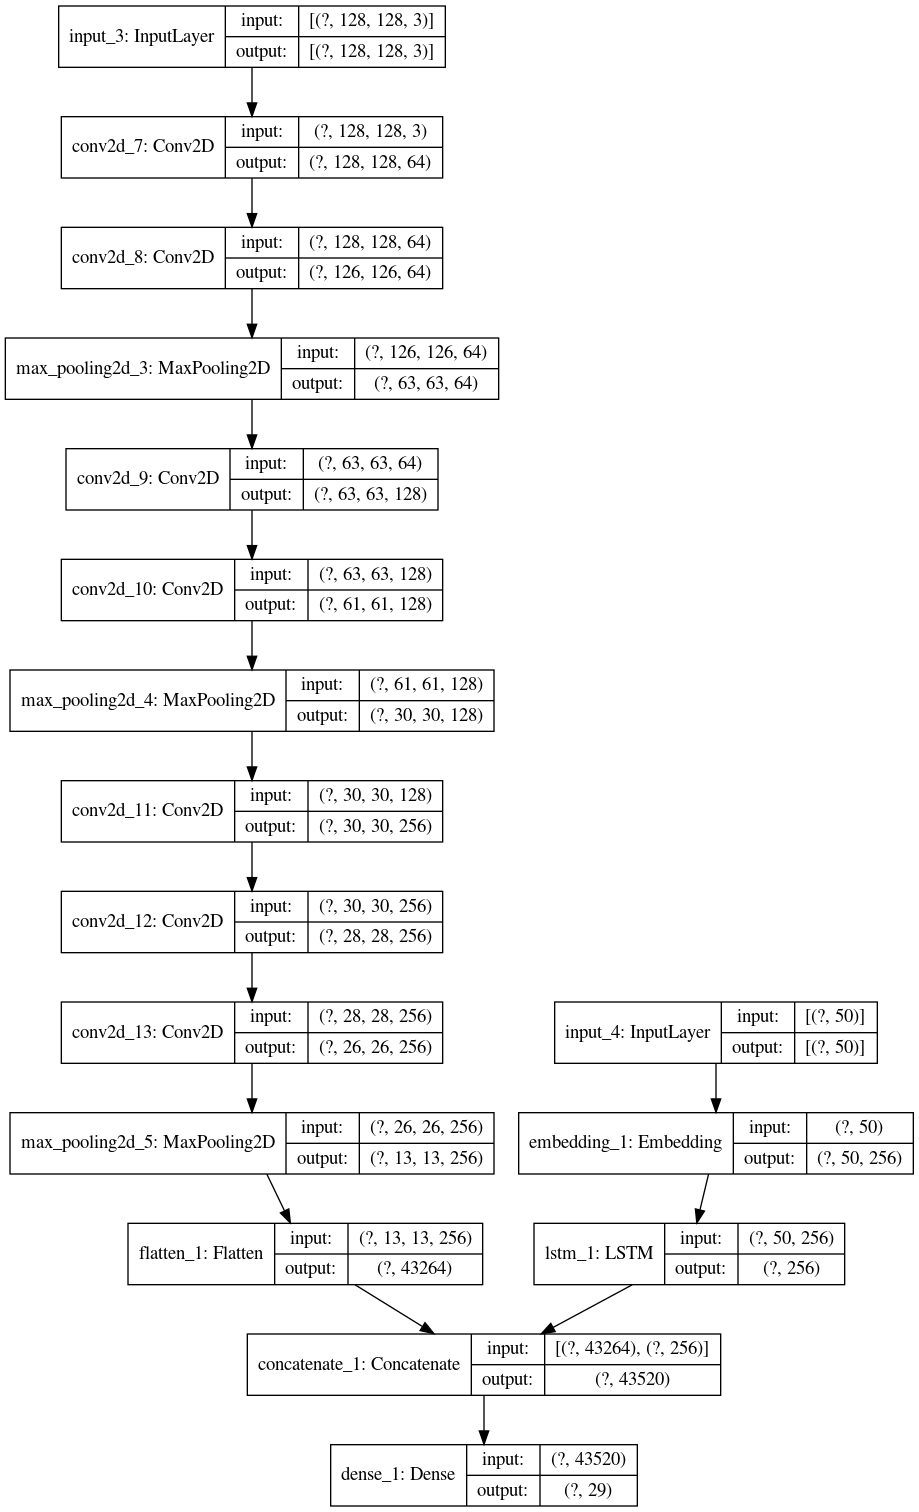

In [13]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [19]:
epochs=50
with tf.device(device):
       history =  model.fit(train_dataset,
                  validation_data=validation_dataset,
                  epochs=epochs)

Epoch 1/50
547/547 [==============================] - 474s 866ms/step - loss: 2.6092 - accuracy: 0.2134 - val_loss: 2.4714 - val_accuracy: 0.2478
Epoch 2/50
547/547 [==============================] - 463s 847ms/step - loss: 2.4715 - accuracy: 0.2400 - val_loss: 2.4686 - val_accuracy: 0.2478
Epoch 3/50
547/547 [==============================] - 464s 848ms/step - loss: 2.4692 - accuracy: 0.2405 - val_loss: 2.4677 - val_accuracy: 0.2478
Epoch 4/50
547/547 [==============================] - 471s 861ms/step - loss: 2.4642 - accuracy: 0.2405 - val_loss: 2.4565 - val_accuracy: 0.2478
Epoch 5/50
547/547 [==============================] - 464s 848ms/step - loss: 2.3024 - accuracy: 0.2613 - val_loss: 2.1664 - val_accuracy: 0.2825
Epoch 6/50
547/547 [==============================] - 464s 849ms/step - loss: 2.3189 - accuracy: 0.2562 - val_loss: 2.6368 - val_accuracy: 0.2077
Epoch 7/50
547/547 [==============================] - 464s 848ms/step - loss: 2.3790 - accuracy: 0.2279 - val_loss: 2.1247 -

In [20]:
losses = pd.DataFrame(history.history)

<AxesSubplot:>

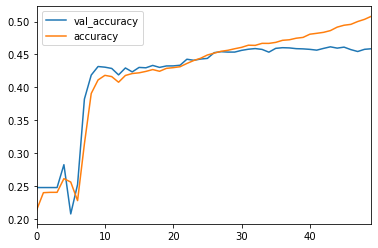

In [21]:
losses[['val_accuracy', 'accuracy']].plot()

<AxesSubplot:>

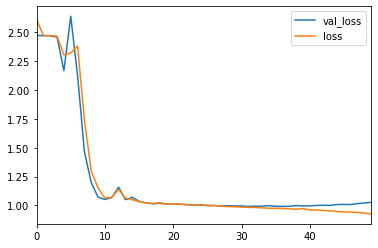

In [22]:
losses[['val_loss', 'loss']].plot()

In [23]:
import datetime

date_str = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
val_accuracy = losses[['val_accuracy']].values[-1][0]
date_str = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
checkpoint_path = f"models/cnn_plus_lstm-{date_str}-{val_accuracy}-{epochs}"
model.save(checkpoint_path)


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/cnn_plus_lstm-2021-05-21_01:17:49-0.45873332023620605-50/assets


In [15]:
# checkpoint_path = 'models/cnn_plus_lstm-2021-05-21_01:17:49-0.45873332023620605-50'
# model = tf.keras.models.load_model(checkpoint_path)

In [16]:
# predictions = model.predict(validation_dataset)